# A Simulation Tool for Signals with Smoothness Constraints

A simulation tool that allows adjustment of the smoothness parameters to simulate noise-free signals for 
Instantaneous State InSAR.

### Description

1. Parameter setting for the smoothness constraints, including the velocity standard deviation, 
and velocity decorrelation time.
2. Simulation of noise-free signals using an exponentially correlated and mean-reverting velocity model.
3. Generation of figures corresponding to the simulated noise-free signals.

### Usage Instructions

1. **Required Python packages:** `numpy`, `pandas`, `matplotlib`
2. Run the notebook sequentially from top to bottom.
3. Adjust the parameter settings to represent the expected signal behavior.


# Import libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setting parameters

In [ ]:
sim_num = 100    # number of simulated time series
sigma_vs = np.array([1, 3, 10])  # values of the velocity stndard deviation [mm/yr] for simulation
L_days = np.array([30,150,365])  # values of the velocity decorrelation time [days] for simulation
Ls = L_days/365  # velocity decorrelation time [yr]


delta_t_day = 6  # satellite revisit interval [days]
delta_t = delta_t_day/365  # satellite revisit interval [yr]
start_date = '2015-1-1'  # start date of the simulated time series
end_date = '2025-1-1'  # end date of the simulated time series


time = pd.date_range(start = start_date, end = end_date, freq = '%sd'%delta_t_day).strftime('%Y-%m-%d')  # time [Y-m-d] for the simulated time series
time = pd.to_datetime(time)
days = np.arange(0, delta_t_day*len(time), delta_t_day)  # time [days] for the simulated time series
years = days/365  # time [yr] for the simulated time series

# Define functions

In [ ]:
def phi_exp_corr(dt, L):
    """State transition matrix for exponentially correlated velocity."""
    a12 = L * (1 - np.exp(-dt / L))
    a22 = np.exp(-dt / L)
    return np.array([[1, a12], [0, a22]])

def q_d_exp_corr(sigma_v, dt, L):
    """Process noise covariance matrix for exponentially correlated noise."""
    q11 = 2 * L * (dt - 3 * L / 2 + 2 * L * np.exp(-dt / L) - L / 2 * np.exp(-2 * dt / L))
    q21 = 2 * L * (-np.exp(-dt / L) + 1 / 2 * (1 + np.exp(-2 * dt / L)))
    q22 = 1 - np.exp(-2 * dt / L)
    Q_d = np.array([[q11, q21], [q21, q22]])
    return sigma_v**2 * Q_d

def simulate_time_series(sigma_v, L, years, x0=np.array([[0], [0]]), Q0=None):
    """One simulation of position (displacement) and velocity time series with the corresponding variance-covariance matrix."""

    
    if Q0 is None:
        Q0 = np.array([[0, 0], [0, sigma_v**2]])

    x_hat = x0.copy()
    Q_xhat = Q0.copy()

    x_hats = [x_hat]
    Q_xhats = [Q_xhat]

    for n in range(1,len(years)):
        dt = years[n]-years[n-1]
        phi = phi_exp_corr(dt, L)
        Q_d = q_d_exp_corr(sigma_v, dt, L)  # process noise
        noise = np.random.multivariate_normal([0, 0], Q_d).reshape(2, 1)
        x_hat = phi @ x_hat + noise
        Q_xhat = phi @ Q_xhat @ phi.T + Q_d

        x_hats.append(x_hat)
        Q_xhats.append(Q_xhat)

    x_hats = np.concatenate(x_hats, axis=1).T 
    Q_xhats = np.stack(Q_xhats)        

    return x_hats, Q_xhats



def polynomial_fitting(x, y, degree=1):
    """
    Perform polynomial fitting on the input data (x, y).

    Parameters:
    
    x : array_like
        Independent variable data points.
    y : array_like 
        Dependent variable data points.
    degree: int
        Degree of the polynomial fit (default is 1 for linear).

    Returns:
    y_fitted : ndarray
        Fitted y values for the given x based on the polynomial fit.
    poly_fn : np.poly1d
        Polynomial function that represents the fit.
    coeffs : ndarray 
        Coefficients of the fitted polynomial.
    """
    # Validate inputs
    if len(x) != len(y):
        raise ValueError("Input arrays 'x' and 'y' must have the same length.")
    if degree < 1:
        raise ValueError("Degree must be at least 1.")

    # Perform polynomial fitting
    coeffs = np.polyfit(x, y, degree)
    poly_fn = np.poly1d(coeffs)
    y_fitted = poly_fn(x)

    return y_fitted, poly_fn, coeffs

# Simulate time series with an exponentially correlated velocity model

In [12]:
vels_exp_mul = np.zeros((len(sigma_vs), len(L_days), sim_num, len(years)))
diss_exp_mul = np.zeros((len(sigma_vs), len(L_days), sim_num, len(years)))
vels_lin = np.zeros((len(sigma_vs), len(L_days), sim_num))
vels_lin_2sigma = np.zeros([len(sigma_vs), len(L_days)])

for i in range(len(sigma_vs)):
    for j in range(len(L_days)):
        for k in range(sim_num):
            x_hats, Q_xhats = simulate_time_series(sigma_vs[i], Ls[j], years)
            diss_exp = x_hats[:, 0]
            vels_exp = x_hats[:, 1]
            y_fitted, poly_fn, coeffs = polynomial_fitting(years, diss_exp, degree=1)

            vels_exp_mul[i,j,k,:] = vels_exp
            diss_exp_mul[i,j,k,:] = diss_exp
            vel_lin = coeffs[0]
            vels_lin[i,j,k] = vel_lin
    
        vels_lin_2sigma[i,j] = 2*np.std(vels_lin[i,j,:])

# Plot for the simulated velocity time series

In [13]:
import string
import matplotlib.dates as mdates
labels = list(string.ascii_lowercase)  # ['a', 'b', 'c', ..., 'z']

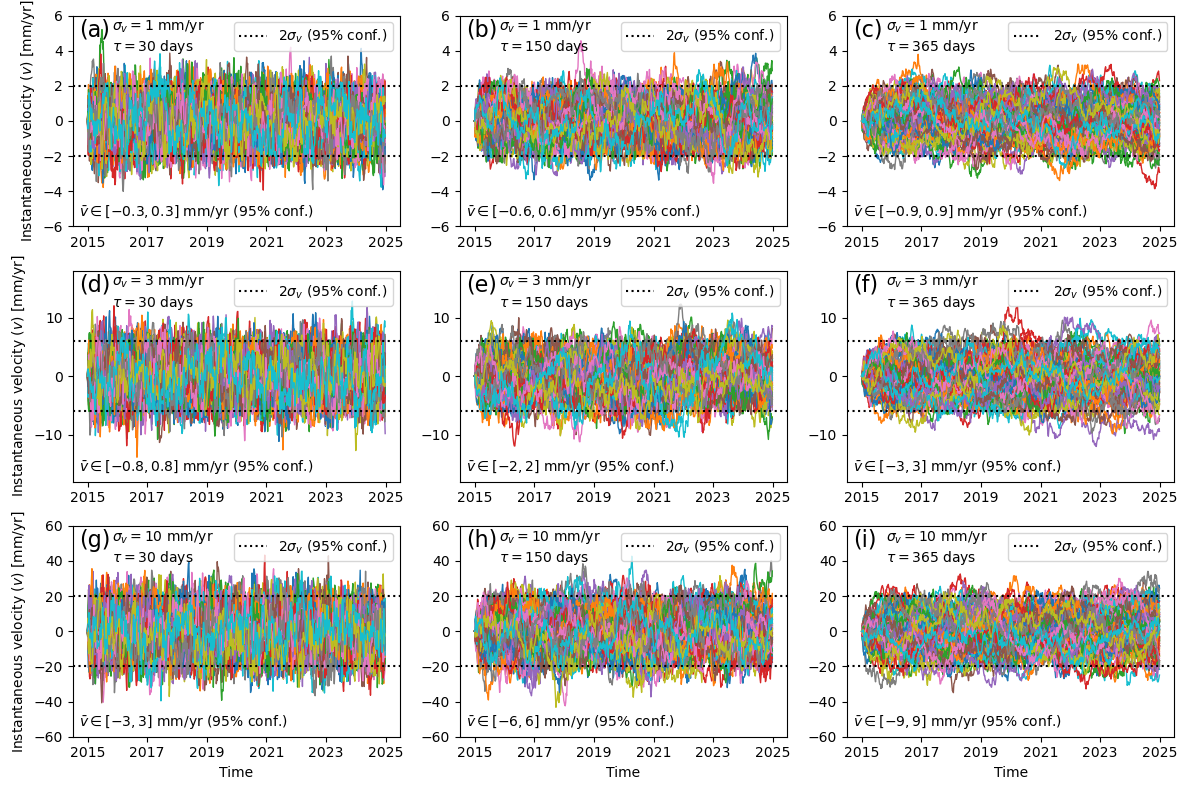

In [14]:
n = 0
plt.figure(figsize = (12,8))
for i in range(len(sigma_vs)):
    for j in range(len(L_days)):
        n=n+1
        ax = plt.subplot(len(sigma_vs), len(L_days), n)
        for k in range(sim_num):
            ax.plot(time, vels_exp_mul[i,j,k,:], linewidth = 1)

        if 7<= n <= 9:
            ax.set_xlabel('Time')
        if n==1 or n==4 or n==7:
            ax.set_ylabel('Instantaneous velocity ($v$) [mm/yr]')
        for ax in plt.gcf().get_axes():
            year_ticks = np.array(['2015-01-01', '2017-01-01', '2019-01-01',
                                '2021-01-01', '2023-01-01', '2025-01-01'], dtype='datetime64')
            ax.set_xticks(year_ticks)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        if 1<=n<=3:
            ax.set_ylim([-sigma_vs[0]*6,sigma_vs[0]*6])
        if 4<=n<=6:
            ax.set_ylim([-sigma_vs[1]*6,sigma_vs[1]*6])
        if 7<=n<=9:
            ax.set_ylim([-sigma_vs[2]*6,sigma_vs[2]*6])
        
        ax.text(0.12, 0.93, '$\sigma_{v} = %s$ mm/yr' % sigma_vs[i], transform=ax.transAxes)
        ax.text(0.12, 0.83, rf'$\tau = {int(L_days[j])}$ days', transform=ax.transAxes)
        ax.text(0.02, 0.9, f'({labels[n-1]})', fontsize=16, transform=ax.transAxes)

        if n<=4:
            ax.text(0.02, 0.05, rf'$\bar{{v}} \in [-{vels_lin_2sigma[i,j]:.1f}, {vels_lin_2sigma[i,j]:.1f}]$ mm/yr (95% conf.)', transform=ax.transAxes)
        else:
            ax.text(0.02, 0.05, rf'$\bar{{v}} \in [-{vels_lin_2sigma[i,j]:.0f}, {vels_lin_2sigma[i,j]:.0f}]$ mm/yr (95% conf.)', transform=ax.transAxes)

        ax.axhline(y=-2*sigma_vs[i],linestyle = ':',color='black', label = '2$\sigma_v$ (95$\%$ conf.)')
        ax.axhline(y=2*sigma_vs[i],linestyle = ':',color='black')
        ax.legend(loc=1)

plt.tight_layout()
plt.show()

# Plot for the simulated position/displacement time series (with the same scale of y-axis)

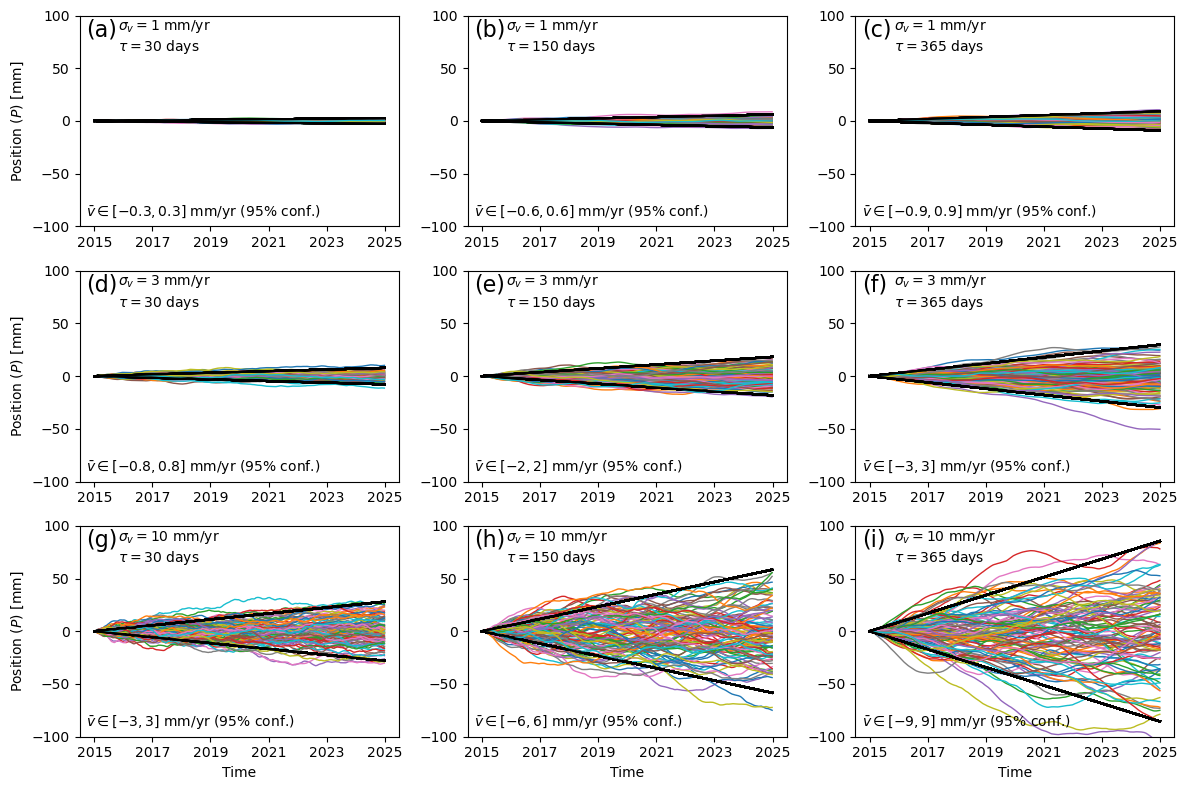

In [15]:
ylim = 100  # maximum value of the range of the y-axis
n = 0
plt.figure(figsize = (12,8))
for i in range(len(sigma_vs)):
    for j in range(len(L_days)):
        n=n+1
        ax = plt.subplot(len(sigma_vs), len(L_days), n)
        for k in range(sim_num):
            ax.plot(time, diss_exp_mul[i,j,k,:], linewidth = 1)
            dis_range1 = vels_lin_2sigma[i,j]*years
            dis_range2 = -vels_lin_2sigma[i,j]*years
            ax.plot(time, dis_range1, color = 'black', linewidth = 1.5)
            ax.plot(time, dis_range2, color = 'black', linewidth = 1.5)
            
        if n == 1 or n==4 or n==7:
            ax.set_ylabel('Position ($P$) [mm]')
        if 7<=n<=9:
            ax.set_xlabel('Time')
        
        for ax in plt.gcf().get_axes():
            year_ticks = np.array(['2015-01-01', '2017-01-01', '2019-01-01',
                                '2021-01-01', '2023-01-01', '2025-01-01'], dtype='datetime64')
            ax.set_xticks(year_ticks)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        ax.text(0.12, 0.93, '$\sigma_{v} = %s$ mm/yr' % sigma_vs[i], transform=ax.transAxes)
        ax.text(0.12, 0.83, rf'$\tau = {int(L_days[j])}$ days', transform=ax.transAxes)
        ax.text(0.02, 0.9, f'({labels[n-1]})', fontsize=16, transform=ax.transAxes)

        if n<=4:
            ax.text(0.02, 0.05, rf'$\bar{{v}} \in [-{vels_lin_2sigma[i,j]:.1f}, {vels_lin_2sigma[i,j]:.1f}]$ mm/yr (95% conf.)', transform=ax.transAxes)
        else:
            ax.text(0.02, 0.05, rf'$\bar{{v}} \in [-{vels_lin_2sigma[i,j]:.0f}, {vels_lin_2sigma[i,j]:.0f}]$ mm/yr (95% conf.)', transform=ax.transAxes)

        ax.set_ylim([-ylim,ylim])
        
plt.tight_layout()
plt.show()

# Plot for the simulated position/displacement time series (with the different scale of y-axis)

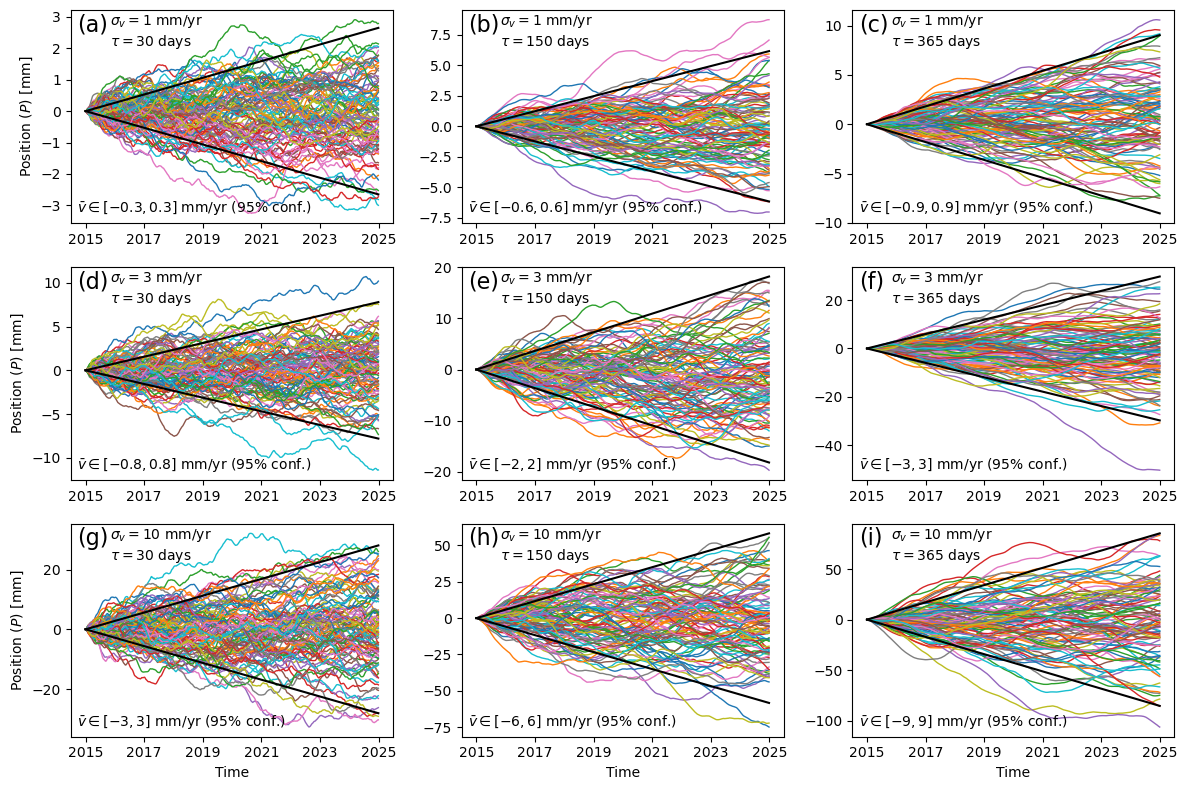

In [16]:
n = 0
plt.figure(figsize = (12,8))
for i in range(len(sigma_vs)):
    for j in range(len(L_days)):
        n=n+1
        ax = plt.subplot(len(sigma_vs), len(L_days), n)
        for k in range(sim_num):
            ax.plot(time, diss_exp_mul[i,j,k,:], linewidth = 1)
        dis_range1 = vels_lin_2sigma[i,j]*years
        dis_range2 = -vels_lin_2sigma[i,j]*years
        ax.plot(time, dis_range1, color = 'black', linewidth = 1.5)
        ax.plot(time, dis_range2, color = 'black', linewidth = 1.5)

        if 7<= n <= 9:
            ax.set_xlabel('Time')
        if n==1 or n==4 or n==7:
            ax.set_ylabel('Position ($P$) [mm]')
        for ax in plt.gcf().get_axes():
            year_ticks = np.array(['2015-01-01', '2017-01-01', '2019-01-01',
                                '2021-01-01', '2023-01-01', '2025-01-01'], dtype='datetime64')
            ax.set_xticks(year_ticks)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        ax.text(0.12, 0.93, '$\sigma_{v} = %s$ mm/yr' % sigma_vs[i], transform=ax.transAxes)
        ax.text(0.12, 0.83, rf'$\tau = {int(L_days[j])}$ days', transform=ax.transAxes)
        ax.text(0.02, 0.9, f'({labels[n-1]})', fontsize=16, transform=ax.transAxes)

        if n<=4:
            ax.text(0.02, 0.05, rf'$\bar{{v}} \in [-{vels_lin_2sigma[i,j]:.1f}, {vels_lin_2sigma[i,j]:.1f}]$ mm/yr (95% conf.)', transform=ax.transAxes)
        else:
            ax.text(0.02, 0.05, rf'$\bar{{v}} \in [-{vels_lin_2sigma[i,j]:.0f}, {vels_lin_2sigma[i,j]:.0f}]$ mm/yr (95% conf.)', transform=ax.transAxes)

plt.tight_layout()
plt.show()